# 序論：森林火災、フラクタル構造をした油田、拡散

## パーコレーションとは？

In [1]:
using Pkg
using Random
Pkg.add("Distributions")
using Distributions
Pkg.add("Plots")
using Plots
Pkg.add("PyPlot")
pyplot()

   Updating registry at `~/.julia/registries/General`
   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %.0 %

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


Plots.PyPlotBackend()

In [2]:
"""
    binomialmap(p, dims）
    dimsで示される行列に二項分布（確率p）を生成する
"""
function binomialmap(p::Float64, dims::Tuple{Int,Int})
      return rand(Binomial(1,p),dims[1],dims[2])
end

"""
    binomialmap(p, s）
    s×sで示される正方行列に二項分布（確率p）を生成する
"""
function binomialmap(p::Float64, s::Int)
      return rand(Binomial(1,p),s,s)
end


binomialmap

In [3]:
"""
    blockmap(data; color, yflip, title, titlelocation)
    dataで示されるマップに対応して，colorで示される色で表示する
    yflipがtrueの場合は上下を反転して表示する
"""
function blockmap(data::Array{Int,2}; color::Array{Symbol}, yflip::Bool = true, 
                  title::String = "", titlelocation::String = "center")
    heatmap(data, color = color, yflip = yflip, 
            framestyle = :grid, showaxis = false, bg = :black, colorbar = :none, aspectratio = 1,
            title = title, titlelocation  = titlelocation)
end

blockmap

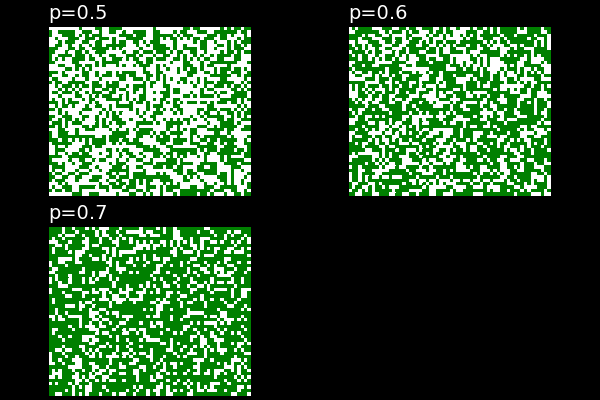

In [4]:
plt=[]
for p = 0.5:0.1:0.7
    data = binomialmap(p,(50,60))
    push!(plt,blockmap(data, color = [:white,:green], title = "p=$(p)", titlelocation = "left"))
end
plot(plt...)